# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports:" data-toc-modified-id="Imports:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports:</a></div><div class="lev1 toc-item"><a href="#Set-some-important-variables-+-working-environment:" data-toc-modified-id="Set-some-important-variables-+-working-environment:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set some important variables + working environment:</a></div><div class="lev1 toc-item"><a href="#Read-raw-data:" data-toc-modified-id="Read-raw-data:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read raw data:</a></div><div class="lev1 toc-item"><a href="#Data-preparation:" data-toc-modified-id="Data-preparation:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data preparation:</a></div><div class="lev2 toc-item"><a href="#Convert-watch-accelerometer-to-phone-units-(m/sec^2):" data-toc-modified-id="Convert-watch-accelerometer-to-phone-units-(m/sec^2):-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Convert watch accelerometer to phone units ($m/sec^2$):</a></div><div class="lev2 toc-item"><a href="#Trim-steps'-transition-data:" data-toc-modified-id="Trim-steps'-transition-data:-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Trim steps' transition data:</a></div><div class="lev2 toc-item"><a href="#For-each-sample,-add-(1)-accelerometer-norm-and-(2)-step's-norm-STD:" data-toc-modified-id="For-each-sample,-add-(1)-accelerometer-norm-and-(2)-step's-norm-STD:-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>For each sample, add (1) accelerometer norm and (2) step's norm STD:</a></div>

# Imports:

In [1]:
import os
os.chdir('C:\\Users\\imazeh\\Itzik\\Health_prof\\git_team\\DataScientists')
from Utils.Visualization import box_plot
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats.stats import pearsonr, ttest_ind
from os.path import join, sep
import Teva.config as c
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# Set some important variables + working environment:

In [2]:
valid_users = c.valid_users
watch_acc_base = c.watch_acc_baseline
phone_acc_base = c.phone_acc_baseline
statistics = ['median', 'mean', np.std]
min_val = c.report_values[0]
max_val = c.report_values[-1]

static_steps_clinic = ['Sit extended', 'Sit relaxed', 'Stand']
static_steps_home = ['Sit relaxed', 'Stand']

In [3]:
trim_dict = {'TUaG': {'start':2, 'end':2},
             'Sit relaxed': {'start':2, 'end':0},
             'Sit extended': {'start':2, 'end':0},
             'Stand': {'start':2, 'end':0},
             'Walk': {'start':2, 'end':2},
             'Drink': {'start':2, 'end':2},
             'Rotate hands': {'start':2, 'end':0}
            }

In [4]:
cloud = False
if cloud:
    data_path = c.cloud_data_path
else:
    data_path = c.data_path

# Read raw data:

In [5]:
# clinic_assessments_watch_acc_df = pd.read_pickle(c.clinic_assessments_watch_acc_pkl_file_path)
# clinic_assessments_watch_acc_df.name = 'clinic_assessments_watch_acc'

clinic_steps_watch_acc_df = pd.read_pickle(c.clinic_steps_watch_acc_pkl_file_path)
clinic_steps_watch_acc_df.name = 'clinic_steps_watch_acc'

# home_assessments_watch_acc_df = pd.read_pickle(c.home_assessments_watch_acc_pkl_file_path)
# home_assessments_watch_acc_df.name = 'home_assessments_watch_acc'

home_steps_watch_acc_df = pd.read_pickle(c.home_steps_watch_acc_pkl_file_path)
home_steps_watch_acc_df.name = 'home_steps_watch_acc'

# home_reminders_watch_acc_df = pd.read_pickle(c.home_reminders_watch_acc_pkl_file_path)
# home_reminders_watch_acc_df.name = 'home_reminders_watch_acc'

clinic_steps_phone_acc_df = pd.read_pickle(c.clinic_steps_phone_acc_pkl_file_path)
clinic_steps_phone_acc_df.name = 'clinic_steps_phone_acc'

home_steps_phone_acc_df = pd.read_pickle(c.home_steps_phone_acc_pkl_file_path)
home_steps_phone_acc_df.name = 'home_steps_phone_acc'

# Data preparation:

## Convert watch accelerometer to phone units ($m/sec^2$):

In [6]:
def convert_mili_g_to_msc2(df, cols_to_convert=['x', 'y', 'z']):
    conversion_factor = c.phone_acc_baseline/float(1000)
    for col in cols_to_convert:
        df[col] = df[col]*conversion_factor
    return df

In [7]:
clinic_steps_watch_acc_df = convert_mili_g_to_msc2(clinic_steps_watch_acc_df)
home_steps_watch_acc_df = convert_mili_g_to_msc2(home_steps_watch_acc_df)
# home_reminders_watch_acc_df = convert_mili_g_to_msc2(home_reminders_watch_acc_df)

## Trim steps' transition data:

In [8]:
def trim_assessment_per_step(assess_df, trim_dict, samples_freq=50):
    sorted_assess_df = assess_df.sort_values(by='timestamp', ascending=True)
    steps_list = assess_df['step_name'].unique()
    trimmed_df = pd.DataFrame()
    for step in steps_list:
        step_df = sorted_assess_df[sorted_assess_df['step_name']==step]
        trim_start_sec = trim_dict[step]['start']
        trim_start_samp = trim_start_sec*samples_freq
        trim_end_sec = trim_dict[step]['end']
        if trim_end_sec != 0:
            trim_end_samp = -(trim_end_sec*samples_freq)
        else:
            trim_end_samp = step_df.shape[0]
        trimmed_step = step_df.iloc[trim_start_samp:trim_end_samp]
        trimmed_df = pd.concat([trimmed_df, trimmed_step])
    return trimmed_df

In [9]:
def trim_entire_df_per_step(df, trim_dict, samsamples_freq=50):
    sorted_df = df.sort_values(by='timestamp', ascending=True)
    assessments_list = df['assessment_id'].unique()
    trimmed_entire_df = pd.DataFrame()
    for assess in assessments_list:
        assess_df = sorted_df[sorted_df['assessment_id']==assess]
        trimmed_assess = trim_assessment_per_step(assess_df, trim_dict)
        trimmed_entire_df = pd.concat([trimmed_entire_df, trimmed_assess])
    return trimmed_entire_df

In [10]:
trimmed_clinic_steps_watch_acc = trim_entire_df_per_step(clinic_steps_watch_acc_df, trim_dict)
trimmed_clinic_steps_watch_acc.name = 'trimmed_clinic_steps_watch_acc'

trimmed_clinic_steps_phone_acc = trim_entire_df_per_step(clinic_steps_phone_acc_df, trim_dict)
trimmed_clinic_steps_phone_acc.name = 'trimmed_clinic_steps_phone_acc'

trimmed_home_steps_watch_acc = trim_entire_df_per_step(home_steps_watch_acc_df, trim_dict)
trimmed_home_steps_watch_acc.name = 'trimmed_home_steps_watch_acc'

trimmed_home_steps_phone_acc = trim_entire_df_per_step(home_steps_phone_acc_df, trim_dict)
trimmed_home_steps_phone_acc.name = 'trimmed_home_steps_phone_acc'

## For each sample, add (1) accelerometer norm and (2) step's norm STD:

In [11]:
def enrich_accelerometer_raw_data(df, global_device_baseline):
    # Add the accelerometer's norm:
    df['acc_norm'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    # Calculate the accelerometer norm's standard deviation for each step:
    step_norm_std = df[['assessment_id', 'step_name', 'acc_norm']].groupby(['assessment_id', 'step_name'],
                                                                           as_index=False).agg(np.std, ddof=0)
    df_with_norm_std = df.merge(right=step_norm_std,
                                how='inner',
                                on=['assessment_id', 'step_name'],
                                suffixes=['', '_step_std'])
    return df_with_norm_std

In [12]:
clinic_watch_acc_with_deltas = enrich_accelerometer_raw_data(trimmed_clinic_steps_watch_acc, watch_acc_base)
clinic_phone_acc_with_deltas = enrich_accelerometer_raw_data(trimmed_clinic_steps_phone_acc, phone_acc_base)
home_watch_acc_with_deltas = enrich_accelerometer_raw_data(trimmed_home_steps_watch_acc, watch_acc_base)
home_phone_acc_with_deltas = enrich_accelerometer_raw_data(trimmed_home_steps_phone_acc, phone_acc_base)

In [13]:
clinic_watch_acc_with_deltas.head()

,user_id,assessment_id,assessment_start,assessment_end,timestamp,step_name,x,y,z,patient_report_value,clinician_report_value,acc_norm,acc_norm_step_std
0,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.043,TUaG,-2.235916,2.579149,-8.855405,3.0,4.0,9.490497,2.28504
1,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.063,TUaG,-2.745862,2.324176,-9.708583,3.0,4.0,10.353654,2.28504
2,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.083,TUaG,-1.108151,-1.265058,-11.032481,3.0,4.0,11.159929,2.28504
3,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.103,TUaG,-1.696550,-1.941717,-9.953750,3.0,4.0,10.282299,2.28504
4,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.123,TUaG,-1.480804,0.196133,-9.208444,3.0,4.0,9.328810,2.28504


Step: TUaG
user 82: 1231
user 45: 2508
user 8: 499
user 74: 149
user 94: 3851
user 25: 778
user 51: 942
user 108: 209
user 57: 344


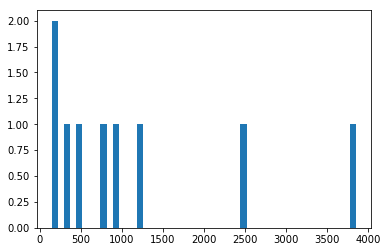

Step: Sit relaxed
user 82: 5873
user 63: 5870
user 45: 5858
user 8: 5934
user 74: 5884
user 94: 5878
user 25: 11593
user 51: 5910
user 108: 5921
user 57: 5823


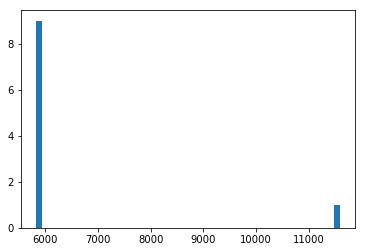

Step: Sit extended
user 82: 2913
user 63: 2861
user 45: 2854
user 8: 2892
user 74: 2942
user 94: 2865
user 25: 5699
user 51: 2880
user 108: 2886
user 57: 2869


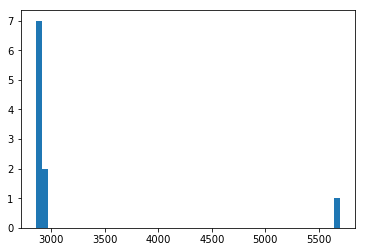

Step: Stand
user 82: 1382
user 63: 1380
user 45: 1377
user 8: 1396
user 74: 1445
user 94: 1382
user 25: 2749
user 51: 1391
user 108: 1391
user 57: 1385


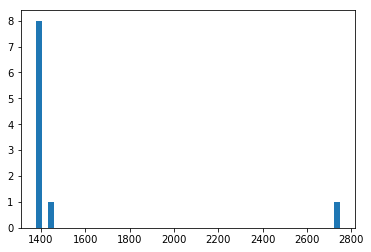

Step: Walk
user 82: 147
user 63: 2415
user 45: 1277
user 8: 548
user 74: 349
user 25: 2301
user 51: 396
user 108: 297
user 57: 593


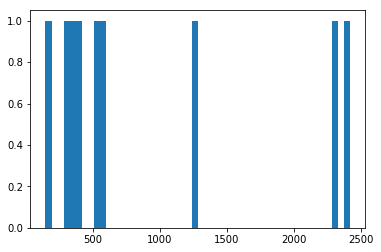

Step: Drink
user 82: 1233
user 63: 1329
user 45: 986
user 8: 785
user 74: 248
user 25: 2792
user 51: 1241
user 108: 99
user 57: 1334


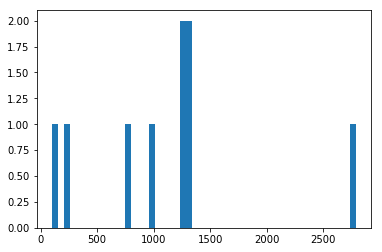

Step: Rotate hands
user 82: 1382
user 63: 1381
user 45: 1296
user 8: 1396
user 74: 1395
user 94: 1382
user 25: 2749
user 51: 1391
user 108: 1392
user 57: 1384


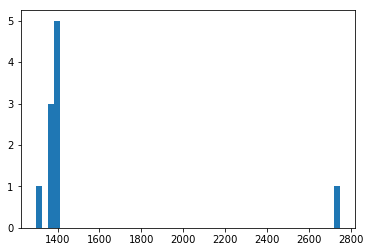

In [26]:
for step in clinic_watch_acc_with_deltas['step_name'].unique():
    print('Step:', step)
    step_lengths = []
    step_df = clinic_watch_acc_with_deltas[clinic_watch_acc_with_deltas['step_name']==step]
    for user in step_df['user_id'].unique():
        user_df = step_df[step_df['user_id']==user]
        user_rows = user_df.shape[0]
        print('user %s: %d' % (user, user_rows))
        
        step_lengths.append(user_df.shape[0])
    plt.hist(step_lengths, bins=50)
    plt.show()

In [37]:
def concat_step_key(row):
    return str(row['assessment_id'])+'_'+str(row['step_name'])

In [39]:
def make_interval_from_all_data(df):
    df_copy = df.copy()
    df_copy['step_key'] = df_copy.apply(concat_step_key, axis=1)
    df_copy.drop(['assessment_start', 'assessment_end'], axis=1, inplace=True)
    return df_copy

In [40]:
test = make_interval_from_all_data(trimmed_clinic_steps_watch_acc)
test.head()

,user_id,assessment_id,assessment_start,assessment_end,timestamp,step_name,x,y,z,patient_report_value,clinician_report_value,acc_norm,step_key
748,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.043,TUaG,-2.235916,2.579149,-8.855405,3.0,4.0,9.490497,1489765988342_TUaG
749,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.063,TUaG,-2.745862,2.324176,-9.708583,3.0,4.0,10.353654,1489765988342_TUaG
750,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.083,TUaG,-1.108151,-1.265058,-11.032481,3.0,4.0,11.159929,1489765988342_TUaG
751,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.103,TUaG,-1.696550,-1.941717,-9.953750,3.0,4.0,10.282299,1489765988342_TUaG
752,82,1489765988342,2017-03-17 15:43:54.743,2017-03-17 15:53:08.333,2017-03-17 15:44:12.123,TUaG,-1.480804,0.196133,-9.208444,3.0,4.0,9.328810,1489765988342_TUaG


In [28]:
print(trimmed_clinic_steps_watch_acc.dtypes)

user_id                            int64
assessment_id                      int64
assessment_start          datetime64[ns]
assessment_end            datetime64[ns]
timestamp                 datetime64[ns]
step_name                         object
x                                float64
y                                float64
z                                float64
patient_report_value             float64
clinician_report_value           float64
acc_norm                         float64
acc_norm_step_std                float64
dtype: object
user_id                            int64
assessment_id                      int64
assessment_start          datetime64[ns]
assessment_end            datetime64[ns]
timestamp                 datetime64[ns]
step_name                         object
x                                float64
y                                float64
z                                float64
patient_report_value             float64
clinician_report_value           float64
ac